In [1]:
import sys

import matplotlib.pyplot as plt
import json
import os.path
import itertools

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

%load_ext autoreload
%autoreload 2

## Make datasets without noise

In [ ]:
DATA_BASEPATH = "../dysts/data/"
np.random.seed(0)

num_periods = {
    "train": 12,
    "test": 12
}
for (ts_type, subset, pts_per_period) in itertools.product(
                                                      ["univariate", "multivariate"], 
                                                      ["train", "test"], 
                                                      [15, 100]
                                                    ):
    output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}.json")
    dataset = dict()

    for i, name in enumerate(get_attractor_list()):
        print(name)
        dataset[name] = dict()
        model = getattr(dysts.flows, name)()
        # make initial conditions for train, val, test
        [train_ic, val_ic, test_ic] = sample_initial_conditions(model, 3)

        if subset == "train":
            model.ic = train_ic
        elif subset == "val":
            model.ic = val_ic
        elif subset == "test":
            model.ic = test_ic
        else:
            pass
        tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, pts_per_period=pts_per_period, 
                                       resample=True, return_times=True)


        if ts_type == "univariate":
            values = sol[:, 0].tolist()
        elif ts_type == "multivariate":
            values = sol.tolist()
        else:
            warnings.warn("Specified time series type not \"univariate\" or \"multivariate\", falling back to univariate")
            values = sol[:, 0]

        dataset[name]["time"] = tpts.tolist()
        dataset[name]["dt"] = np.median(np.diff(tpts))

        dataset[name]["values"] = values
        with open(output_path, 'w') as f:
            json.dump(dataset, f, indent=4)

# Make dataset with noise

In [250]:
# sol = model.make_trajectory(1000, pts_per_period=pts_per_period, resample=True)

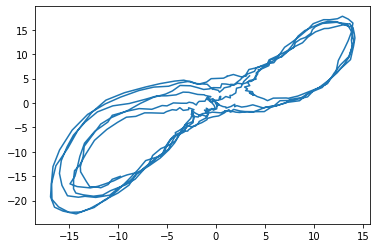

In [78]:

sol = Lorenz().make_trajectory(500, noise=0.2, resample=True)
plt.plot(sol[:, 0], sol[:, 1])

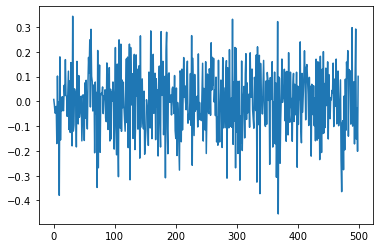

In [273]:
plt.plot(sol[:, 0]- sol_detrend)

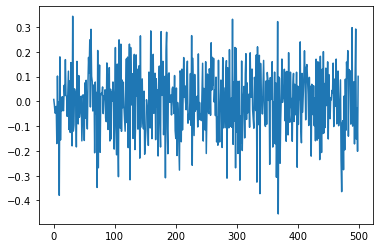

In [277]:
plt.plot(sol[:, 0]- sol_detrend)

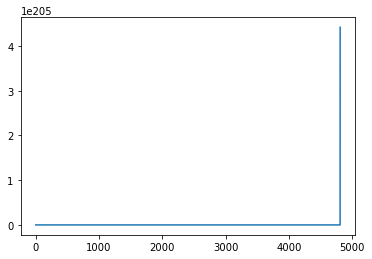

In [311]:
plt.plot(noise_traj[:, 1])

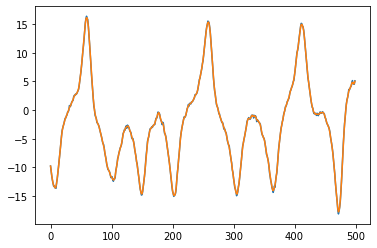

In [276]:
import scipy.signal
# sol_detrend = scipy.signal.detrend(sol[:, 0])

plt.plot(sol[:, 0])
plt.plot(sol_detrend)

In [17]:
noise_traj

array([[ 1.89276643, -2.99581985, -1.2981937 ],
       [ 2.14669312, -2.39724919, -1.3853376 ],
       [ 2.37954705, -1.81549902, -1.44325431],
       ...,
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan]])

In [21]:
import scipy.signal
DATA_BASEPATH = "../dysts/data/"
np.random.seed(0)


import torch
from torchsde import sdeint
from dysts.flows import Lorenz
class SDE(torch.nn.Module):

    def __init__(self, rhs, sigma):
        super().__init__()
        self.noise_type="diagonal"
        self.sde_type = "ito"
        self.sigma = sigma
        self.rhs = rhs

    def f(self, t, y):
        return self.rhs(y, t)

    def g(self, t, y):
        return self.sigma * y


# ts_type = "multivariate"
# subset = "train"
# pts_per_period = 15 # granularity 15 or 100
# pts_per_period = 100 # granularity 15 or 100


# num_periods = {
#     "large": 100,
#     "train": 10,
#     "val": 2,
#     "test": 2
# }

## iterate over uni/multi, train partition, and granularity
# for (ts_type, subset, pts_per_period) in itertools.product(
#                                                       ["univariate", "multivariate"], 
#                                                       ["train", "val", "test"], 
#                                                       [15, 100]
#                                                     ):

# for (ts_type, subset, pts_per_period) in [("univariate", "large", 100)]:

NOISE_FLAG = True
num_periods = {
    "train": 12,
    "test": 12
}
for (ts_type, subset, pts_per_period) in itertools.product(
                                                      ["multivariate", "univariate"], 
                                                      ["train", "test"], 
                                                      [100, 15]
                                                    ):
    
    if NOISE_FLAG:
        output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}_noise.json")
    else:
        output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}.json")
    
    dataset = dict()

    for i, name in enumerate(get_attractor_list()):
        
#         if name != "ForcedVanDerPol":
#             continue
        
        print(name)
        dataset[name] = dict()
        model = getattr(dysts.flows, name)()
        # make initial conditions for train, val, test
        [train_ic, val_ic, test_ic] = sample_initial_conditions(model, 3)

        if subset == "train":
            model.ic = train_ic
        elif subset == "val":
            model.ic = val_ic
        elif subset == "test":
            model.ic = test_ic
        else:
            pass
        tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, pts_per_period=pts_per_period, 
                               resample=True, return_times=True)
        
        
        
#         sol = model.make_trajectory(500, pts_per_period=pts_per_period, resample=True)
        #noise_scale = 0.02 * np.median(np.abs(sol))
        #noise_scale = 0.01 * np.max(np.median(np.abs(sol), axis=1))
        #noise_scale = 0.01 * np.min(np.median(np.abs(sol), axis=1))
#         noise_scale = 0.02 * np.max(np.std(sol, axis=0))
#         noise_scale = 0.01
        #noise_scale = 0.01 * np.min(np.std(sol, axis=0))
        #noise_scale = 0.02 * np.median(np.std(sol, axis=0)) / (10 * np.sqrt(model.dt))
#         noise_scale =  0.01 * np.max(np.std(sol, axis=0)) / (10 * np.sqrt(model.dt))
#         print(model.dt, model.period)
        
        
#         ref_traj = model.make_trajectory(5000, pts_per_period=pts_per_period, resample=False)
#         noise_traj = model.make_trajectory(5000, noise=0.5, pts_per_period=pts_per_period, resample=False)
#         noise_scale = np.max(np.sqrt(np.abs(np.var(noise_traj, axis=0) - np.var(ref_traj, axis=0))))
#         noise_scale = 0.1 * 1.5 / noise_scale
        
#         ref_traj = model.make_trajectory(2, pts_per_period=pts_per_period, resample=True)
#         noise_traj = model.make_trajectory(2, noise=0.5, pts_per_period=pts_per_period, resample=True)
#         noise_scale = np.median(np.abs((ref_traj - noise_traj)[-1]))
#         noise_scale = 0.35 * 0.025 / noise_scale
# #         noise_scale = 0.2 * 2.219312524586793 *  noise_scale
        
    
    
        solver_settings = {
            "pts_per_period" : pts_per_period,
            "resample" : True,
            "method" : "Radau",
            "return_times" : True
        }
        
    
        model.dt /= 10
        
        noise_start = 0.05
        _, noise_traj = model.make_trajectory(5000, noise=noise_start, **solver_settings)
        if np.any(np.isnan(noise_traj)):
            while np.any(np.isnan(noise_traj)):
                np.random.random()
                noise_start *= .5
                _, noise_traj = model.make_trajectory(5000, noise=noise_start, **solver_settings)
        
        all_noise_vals = list()
        for row in noise_traj.T:
            try:
                row_detrend = scipy.signal.savgol_filter(row, 7, 1)
                all_noise_vals.append(np.std(row - row_detrend))
            except:
                pass
        noise_scale = np.min(all_noise_vals)
        noise_scale = 0.005 * 0.025 / noise_scale * (.0007/model.dt)**0.5
        
        noise_scale = 0.1 * np.min(np.std(noise_traj, axis=0)) #* (.0007/model.dt)**-2
        noise_scale = 0.05 * np.median(np.std(noise_traj, axis=0)) * np.sqrt(3/model.embedding_dimension)
        
        noise_scale = 0.025 * np.std(noise_traj, axis=0)# * np.sqrt(3/model.embedding_dimension)
        
        if model.nonautonomous:
            noise_scale[2] = 0
        #noise_scale[model.unbounded_indices] = 0
        
        if name == "ForcedVanDerPol":
            #model.ic = np.array(model.ic) / 10
#             model.dt *= 100
            noise_scale *= 0
    
        try:
            tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, 
                                              noise=noise_scale, 
                                              **solver_settings
                                             )
        except:
            print("Error encountered, reducing timestep")
            model.dt *= 0.1
            tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, 
                                              noise=noise_scale, 
                                             **solver_settings
                                             )
        
        if np.any(np.isnan(sol)):
            # Deal with bad integration
            while np.any(np.isnan(sol)):
                np.random.random()
                noise_scale *= .8
                tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, 
                                                  noise=noise_scale, 
                                                 **solver_settings
                                                 )
                
#         if model.delay:
#             continue
        
#         eq = model
        
#         if hasattr(eq, "_rhs"):
#             param_list = [
#                 getattr(eq, param_name) for param_name in eq.get_param_names()
#             ]
#             rhs = lambda y, t : torch.tensor([eq._rhs.py_func(*y.T, t, *param_list)])
#         else:
#             rhs = lambda y, t : torch.tensor([eq.rhs(y.T, t)])

#         sde = SDE(rhs, torch.tensor(0.03 * np.std(eq.make_trajectory(1000), axis=0)) )
#         sol = sdeint(sde, torch.tensor([eq.ic]), torch.tensor(tpts), dt=eq.dt)
#         sol = np.squeeze(np.array(sol))

        if ts_type == "univariate":
            values = sol[:, 0].tolist()
        elif ts_type == "multivariate":
            values = sol.tolist()
        else:
            warnings.warn("Specified time series type not \"univariate\" or \"multivariate\", falling back to univariate")
            values = sol[:, 0]

        dataset[name]["time"] = tpts.tolist()
        dataset[name]["dt"] = np.median(np.diff(tpts))

        dataset[name]["values"] = values
        with open(output_path, 'w') as f:
            json.dump(dataset, f, indent=4)  
            
    break
    
#     dataset[name]["values"] = 7
    
#     break
#     with open(output_path_multi, 'w') as f:
#         json.dump(dataset, f, indent=4)    

Aizawa
AnishchenkoAstakhov
Arneodo
ArnoldBeltramiChildress
ArnoldWeb


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1923.076923076923
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1923.0769230769233
  warnings.warn(


BeerRNN


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2500.068842076277
  warnings.warn(


BelousovZhabotinsky


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1587.2891671013736
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 4761.867501304121
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 4761.867501304122
  warnings.warn(


BickleyJet
Blasius
BlinkingRotlet


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1041.659315455187
  warnings.warn(


BlinkingVortex


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1792.1263248972532
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1792.126324897253
  warnings.warn(


Bouali
Bouali2
BurkeShaw
CaTwoPlus
CaTwoPlusQuasiperiodic
CellCycle
CellularNeuralNetwork
Chen
ChenLee


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1428.5787060621499
  warnings.warn(


Chua
CircadianRhythm


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1562.5
  warnings.warn(


CoevolvingPredatorPrey


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1515.1178575836107
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1515.1178575836109
  warnings.warn(


Colpitts
Coullet
Dadras


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2272.702142363511
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2272.7021423635106
  warnings.warn(


DequanLi
DoubleGyre
DoublePendulum
Duffing
ExcitableCell


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1249.9999999999998
  warnings.warn(


Finance


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1136.3657247875028
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1136.365724787503
  warnings.warn(


FluidTrampoline
ForcedBrusselator


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1052.6560082516762
  warnings.warn(


ForcedFitzHughNagumo


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2100.865483350447
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2100.8654833504474
  warnings.warn(


ForcedVanDerPol
GenesioTesi
GuckenheimerHolmes
Hadley
Halvorsen
HastingsPowell


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2083.371860070889
  warnings.warn(


HenonHeiles
HindmarshRose


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2173.966993423501
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2173.9669934235017
  warnings.warn(


Hopfield
HyperBao
HyperCai
HyperJha
HyperLorenz
HyperLu
HyperPang
HyperQi
HyperRossler


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/sdeint/integrate.py:480: RuntimeWarning: invalid value encountered in add
  H20 = Yn + fnh # shape (d,)


HyperWang
HyperXu
HyperYan
HyperYangChen
IkedaDelay
Error encountered, reducing timestep


ValueError: NumPy boolean array indexing assignment cannot assign 10 input values to the 1 output values where the mask is true

In [213]:
np.isscalar(9)

True

In [212]:
qq = 
np.isclose([0.1, 0.1 0.1], 0*[0.1, 0.1 0.1])

SyntaxError: invalid syntax (<ipython-input-212-5778dd1a26e4>, line 1)

In [ ]:
(np.ptp(sol, axis=0)/np.ptp(xxxx, axis=0)) > 2.0

In [181]:
dir(getattr(dysts.flows, equation_name)())

['__annotations__',
 '__call__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_data',
 '_postprocessing',
 '_rhs',
 'a',
 'bifurcation_parameter',
 'bound_trajectory',
 'citation',
 'correlation_dimension',
 'data_path',
 'delay',
 'description',
 'dt',
 'embedding_dimension',
 'get_param_names',
 'hamiltonian',
 'ic',
 'initial_conditions',
 'kaplan_yorke_dimension',
 'lyapunov_spectrum_estimated',
 'make_trajectory',
 'maximum_lyapunov_estimated',
 'mu',
 'multiscale_entropy',
 'name',
 'nonautonomous',
 'parameters',
 'params',
 'period',
 'pesin_entropy',
 'random_state',
 'rhs',
 'unbounded_indices',
 'w']

[2]

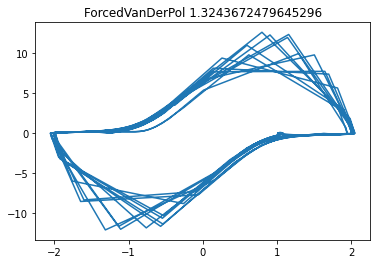

In [17]:
%matplotlib inline
for equation_name in list(dataset.keys())[:19]:
    plt.figure()
    #plt.plot(np.array(dataset[equation_name]["values"]))
    plt.plot(np.array(dataset[equation_name]["values"])[:, 0],np.array(dataset[equation_name]["values"])[:, 1])
    plt.title(equation_name + " " + str(getattr(dysts.flows, equation_name)().correlation_dimension))

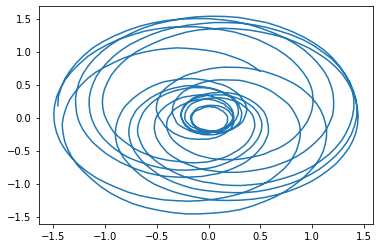

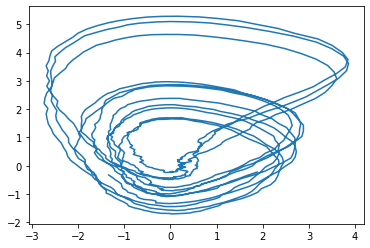

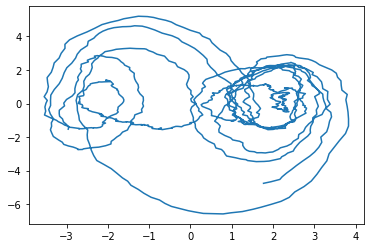

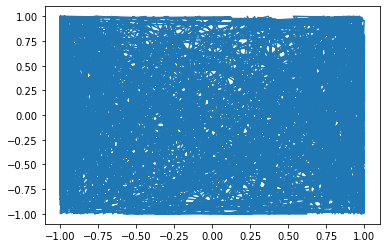

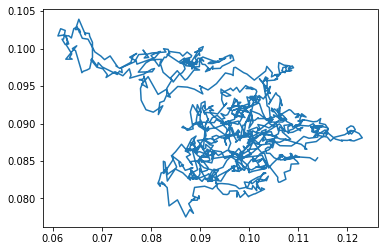

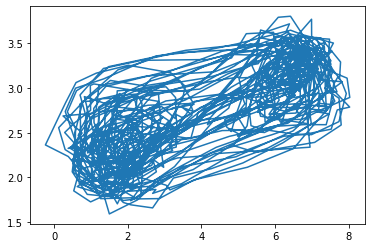

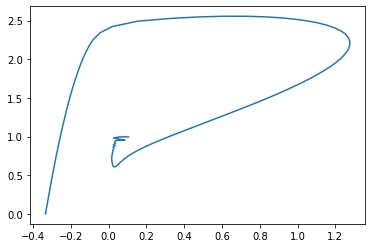

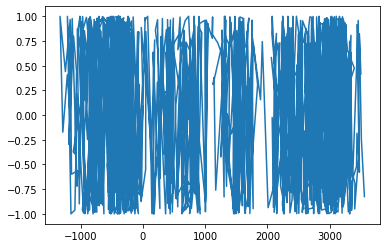

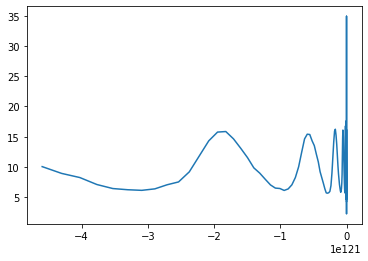

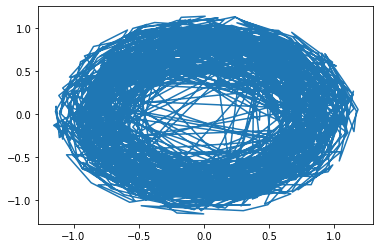

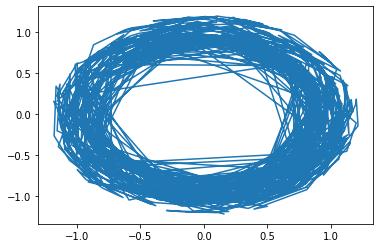

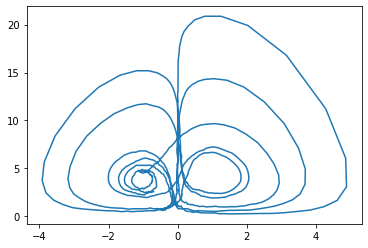

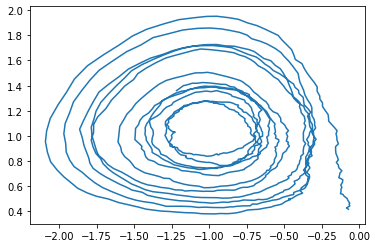

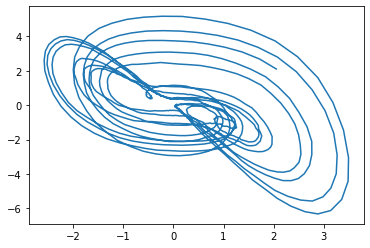

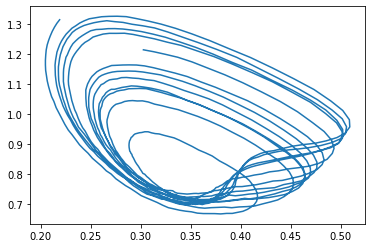

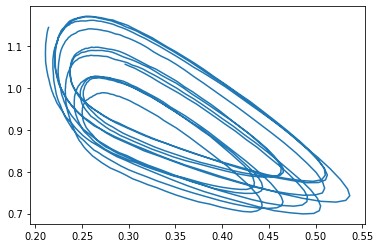

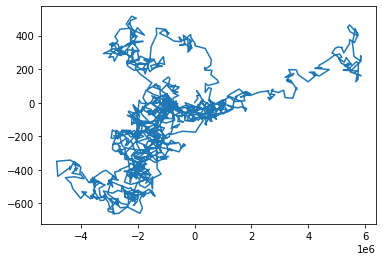

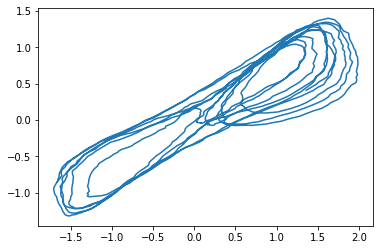

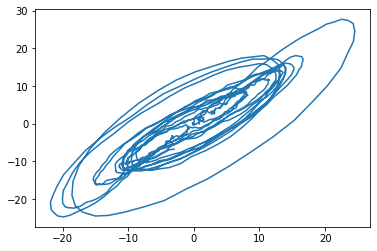

In [7]:
%matplotlib inline
for equation_name in list(dataset.keys())[:19]:
    plt.figure()
    #plt.plot(np.array(dataset[equation_name]["values"]))
    plt.plot(np.array(dataset[equation_name]["values"])[:, 0],np.array(dataset[equation_name]["values"])[:, 1])

In [22]:
%matplotlib inline

plt.plot(np.array(dataset['SprottR']["values"])[:, 0],np.array(dataset['SprottR']["values"])[:, 1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed